# CODIGO GENERAL

## 1.1 - LIBRERIAS

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [128]:
# Configurar la visualización de gráficos inline
%matplotlib inline

# 2.O - CSV DENUNCIAS


### 2.1 - IMPORTACION DE CSV

In [129]:
denuncias_path = ('../datos/csv procesados/limpios_denuncias.csv')
df_denuncias = pd.read_csv(denuncias_path)

In [130]:
df_denuncias.sample(3, random_state=4)

,fecha_ingreso,hora_ingreso,nro_registro_interno,situacion,origen,es_anonima,tema,subtema,provincia,localidad,dependencia_alta,via_ingreso,derivacion_institucion,derivacion_fecha,derivacion_judicializa,denunciante_provincia,denunciante_como_conocio_la_linea
478,2020-04-17,NaN,505455505,Urgencia,Ciudadano,No,Trata,Grooming,Buenos Aires,Florencio Varela,PNR - Línea 145,Línea 145,Protex,2020-04-17 18:45,No,NaN,NaN
5620,2023-05-31,14:28,2545751535,Emergencia,Ciudadano,Sí,Trata,"Explotación sexual niñas, niños y adolescentes",Santa Fe,Rosario,PNR - Línea 145,Línea 145,911,2023-05-31 15:26,Sí,Santa Fe,NaN
1959,2021-04-16,NaN,9494751515,Urgencia,Ciudadano,Sí,Trata,Explotación sexual,Buenos Aires,Ituzaingó,PNR - Línea 145,Línea 145,Protex,2021-04-16 12:29,Sí,NaN,NaN


### 2.2 - COLUMNAS

#### 2.2.1 - TIPOS DE DATOS

In [131]:
df_denuncias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5912 entries, 0 to 5911
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   fecha_ingreso                      5912 non-null   object
 1   hora_ingreso                       2744 non-null   object
 2   nro_registro_interno               5912 non-null   int64 
 3   situacion                          5892 non-null   object
 4   origen                             5912 non-null   object
 5   es_anonima                         5912 non-null   object
 6   tema                               5912 non-null   object
 7   subtema                            5912 non-null   object
 8   provincia                          5441 non-null   object
 9   localidad                          5039 non-null   object
 10  dependencia_alta                   5912 non-null   object
 11  via_ingreso                        5911 non-null   object
 12  deriva

In [132]:
# Convertir hora_ingreso a hora del día
df_denuncias['hora_ingreso'] = pd.to_datetime(df_denuncias['hora_ingreso']).dt.hour

# Convertir fecha_ingreso a datetime
df_denuncias['fecha_ingreso'] = pd.to_datetime(df_denuncias['fecha_ingreso'])

# Lista de columnas para convertir a categorías
categorias_cols = ['situacion', 'origen', 'tema', 'provincia', 'dependencia_alta', 
                   'via_ingreso', 'derivacion_institucion', 'derivacion_judicializa', 
                   'denunciante_provincia', 'es_anonima', 'subtema', 'localidad',
                    'denunciante_como_conocio_la_linea']

# Convertir columnas a categorías en una sola línea
df_denuncias[categorias_cols] = df_denuncias[categorias_cols].astype('category')

/var/folders/sf/zv8w99hn1570688_wf9y1h280000gn/T/ipykernel_8022/4206414756.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_denuncias['hora_ingreso'] = pd.to_datetime(df_denuncias['hora_ingreso']).dt.hour


In [133]:
# Convertir derivacion_fecha_hora a hora del día
df_denuncias['derivacion_fecha'] = pd.to_datetime(df_denuncias['derivacion_fecha'])
df_denuncias['derivacion_hora'] = df_denuncias['derivacion_fecha'].dt.hour

# Obtener año, mes y día de derivacion_fecha en una sola línea
df_denuncias['derivacion_anio'] = df_denuncias['derivacion_fecha'].dt.year
df_denuncias['derivacion_mes'] = df_denuncias['derivacion_fecha'].dt.month
df_denuncias['derivacion_dia'] = df_denuncias['derivacion_fecha'].dt.day

df_denuncias  = df_denuncias.drop('derivacion_fecha', axis=1)

In [134]:
# Convertir derivacion_fecha_hora a hora del día
df_denuncias['fecha_ingreso'] = pd.to_datetime(df_denuncias['fecha_ingreso'])
df_denuncias['ingreso_hora'] = df_denuncias['fecha_ingreso'].dt.hour

# Obtener año, mes y día de derivacion_fecha en una sola línea
df_denuncias['ingreso_anio'] = df_denuncias['fecha_ingreso'].dt.year
df_denuncias['ingreso_mes'] = df_denuncias['fecha_ingreso'].dt.month
df_denuncias['ingreso_dia'] = df_denuncias['fecha_ingreso'].dt.day

df_denuncias  = df_denuncias.drop('fecha_ingreso', axis=1)

#### 2.2.2 - VALORES

In [135]:
# Sin simbolos extranios a remplazar o extraer

#### 2.2.3 - CODIFICACION

##### 2.2.3.0 - CATEGORICOS NOMINALES

In [136]:
columnas_categoricas = df_denuncias.select_dtypes(include=['category'])
columnas_categoricas_nombres =  df_denuncias.select_dtypes(include=['category']).columns

In [137]:
columnas_categoricas.sample(3, random_state= 3)

,situacion,origen,es_anonima,tema,subtema,provincia,localidad,dependencia_alta,via_ingreso,derivacion_institucion,derivacion_judicializa,denunciante_provincia,denunciante_como_conocio_la_linea
2459,Urgencia,Ciudadano,Sí,Trata,"Explotación sexual niñas, niños y adolescentes",Buenos Aires,Trenque Lauquen,PNR - Línea 145,Línea 145,Protex,Sí,NaN,NaN
1507,Urgencia,Ciudadano,No,Trata,Persona desaparecida,Buenos Aires,La Plata,PNR - Línea 145,Correo Institucional,Protex,No,Buenos Aires,NaN
924,Urgencia,Ciudadano,Sí,Trata,Explotación sexual,Buenos Aires,La Plata,PNR - Línea 145,Línea 145,NaN,NaN,NaN,Derivado de otro organismo


In [138]:
# Columnas categoricas nominales
df_denuncias_codificados = df_denuncias
for column in columnas_categoricas_nombres:
    encoder = LabelEncoder()
    df_denuncias_codificados[column] = encoder.fit_transform(df_denuncias_codificados[column].astype(str))

##### 2.2.3.1 - CATEGORICOS ORDINALES

In [139]:
#Columnas categoricas ordinales
# No hay

#### 2.2.4 - ESCALAMIENTO

In [140]:
scaler = MinMaxScaler()
df_denuncias_escalados = scaler.fit_transform(df_denuncias_codificados.copy())
df_denuncias_escalados = pd.DataFrame(df_denuncias_escalados, columns = df_denuncias.columns)

#### 2.2.5 - PORCENTAJE DE VALORES

In [141]:
df_denuncias_escalados.isnull().sum()

hora_ingreso                         3168
nro_registro_interno                    0
situacion                               0
origen                                  0
es_anonima                              0
tema                                    0
subtema                                 0
provincia                               0
localidad                               0
dependencia_alta                        0
via_ingreso                             0
derivacion_institucion                  0
derivacion_judicializa                  0
denunciante_provincia                   0
denunciante_como_conocio_la_linea       0
derivacion_hora                       409
derivacion_anio                       409
derivacion_mes                        409
derivacion_dia                        409
ingreso_hora                            0
ingreso_anio                            0
ingreso_mes                             0
ingreso_dia                             0
dtype: int64

#### 2.2.6 - MEDIDAS DE TENDENCIA CENTRAL

In [142]:
df_denuncias.describe(include='all')

,hora_ingreso,nro_registro_interno,situacion,origen,es_anonima,tema,subtema,provincia,localidad,dependencia_alta,...,denunciante_provincia,denunciante_como_conocio_la_linea,derivacion_hora,derivacion_anio,derivacion_mes,derivacion_dia,ingreso_hora,ingreso_anio,ingreso_mes,ingreso_dia
count,2744.000000,5.912000e+03,5912.000000,5912.000000,5912.000000,5912.0,5912.000000,5912.000000,5912.000000,5912.000000,...,5912.000000,5912.000000,5503.000000,5503.00000,5503.000000,5503.000000,5912.0,5912.000000,5912.000000,5912.000000
mean,13.630466,5.029537e+09,0.763532,16.663227,0.459574,0.0,50.161705,8.099120,465.153586,0.999154,...,15.355548,49.220737,14.143376,2021.46720,6.028893,15.938761,0.0,2021.413227,6.042287,15.852673
std,5.271945,2.828835e+09,0.432838,56.869986,0.498405,0.0,28.392086,8.563099,292.286491,0.029072,...,10.019965,11.363832,5.335932,1.07378,3.359000,8.872725,0.0,1.061745,3.387694,8.861924
min,0.000000,5.050515e+08,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2020.00000,1.000000,1.000000,0.0,2020.000000,1.000000,1.000000
25%,11.000000,2.545841e+09,1.000000,0.000000,0.000000,0.0,34.000000,0.000000,165.000000,1.000000,...,4.000000,54.000000,11.000000,2021.00000,3.000000,8.000000,0.0,2021.000000,3.000000,8.000000
50%,14.000000,5.505305e+09,1.000000,0.000000,0.000000,0.0,34.000000,4.000000,481.000000,1.000000,...,23.000000,54.000000,15.000000,2021.00000,6.000000,16.000000,0.0,2021.000000,6.000000,16.000000
75%,17.000000,7.545455e+09,1.000000,0.000000,1.000000,0.0,75.000000,15.000000,700.250000,1.000000,...,24.000000,54.000000,18.000000,2022.00000,9.000000,24.000000,0.0,2022.000000,9.000000,24.000000
max,23.000000,9.494948e+09,2.000000,307.000000,1.000000,0.0,133.000000,24.000000,907.000000,1.000000,...,24.000000,68.000000,23.000000,2023.00000,12.000000,31.000000,0.0,2023.000000,12.000000,31.000000


### 2.3.0 - CORRELACION

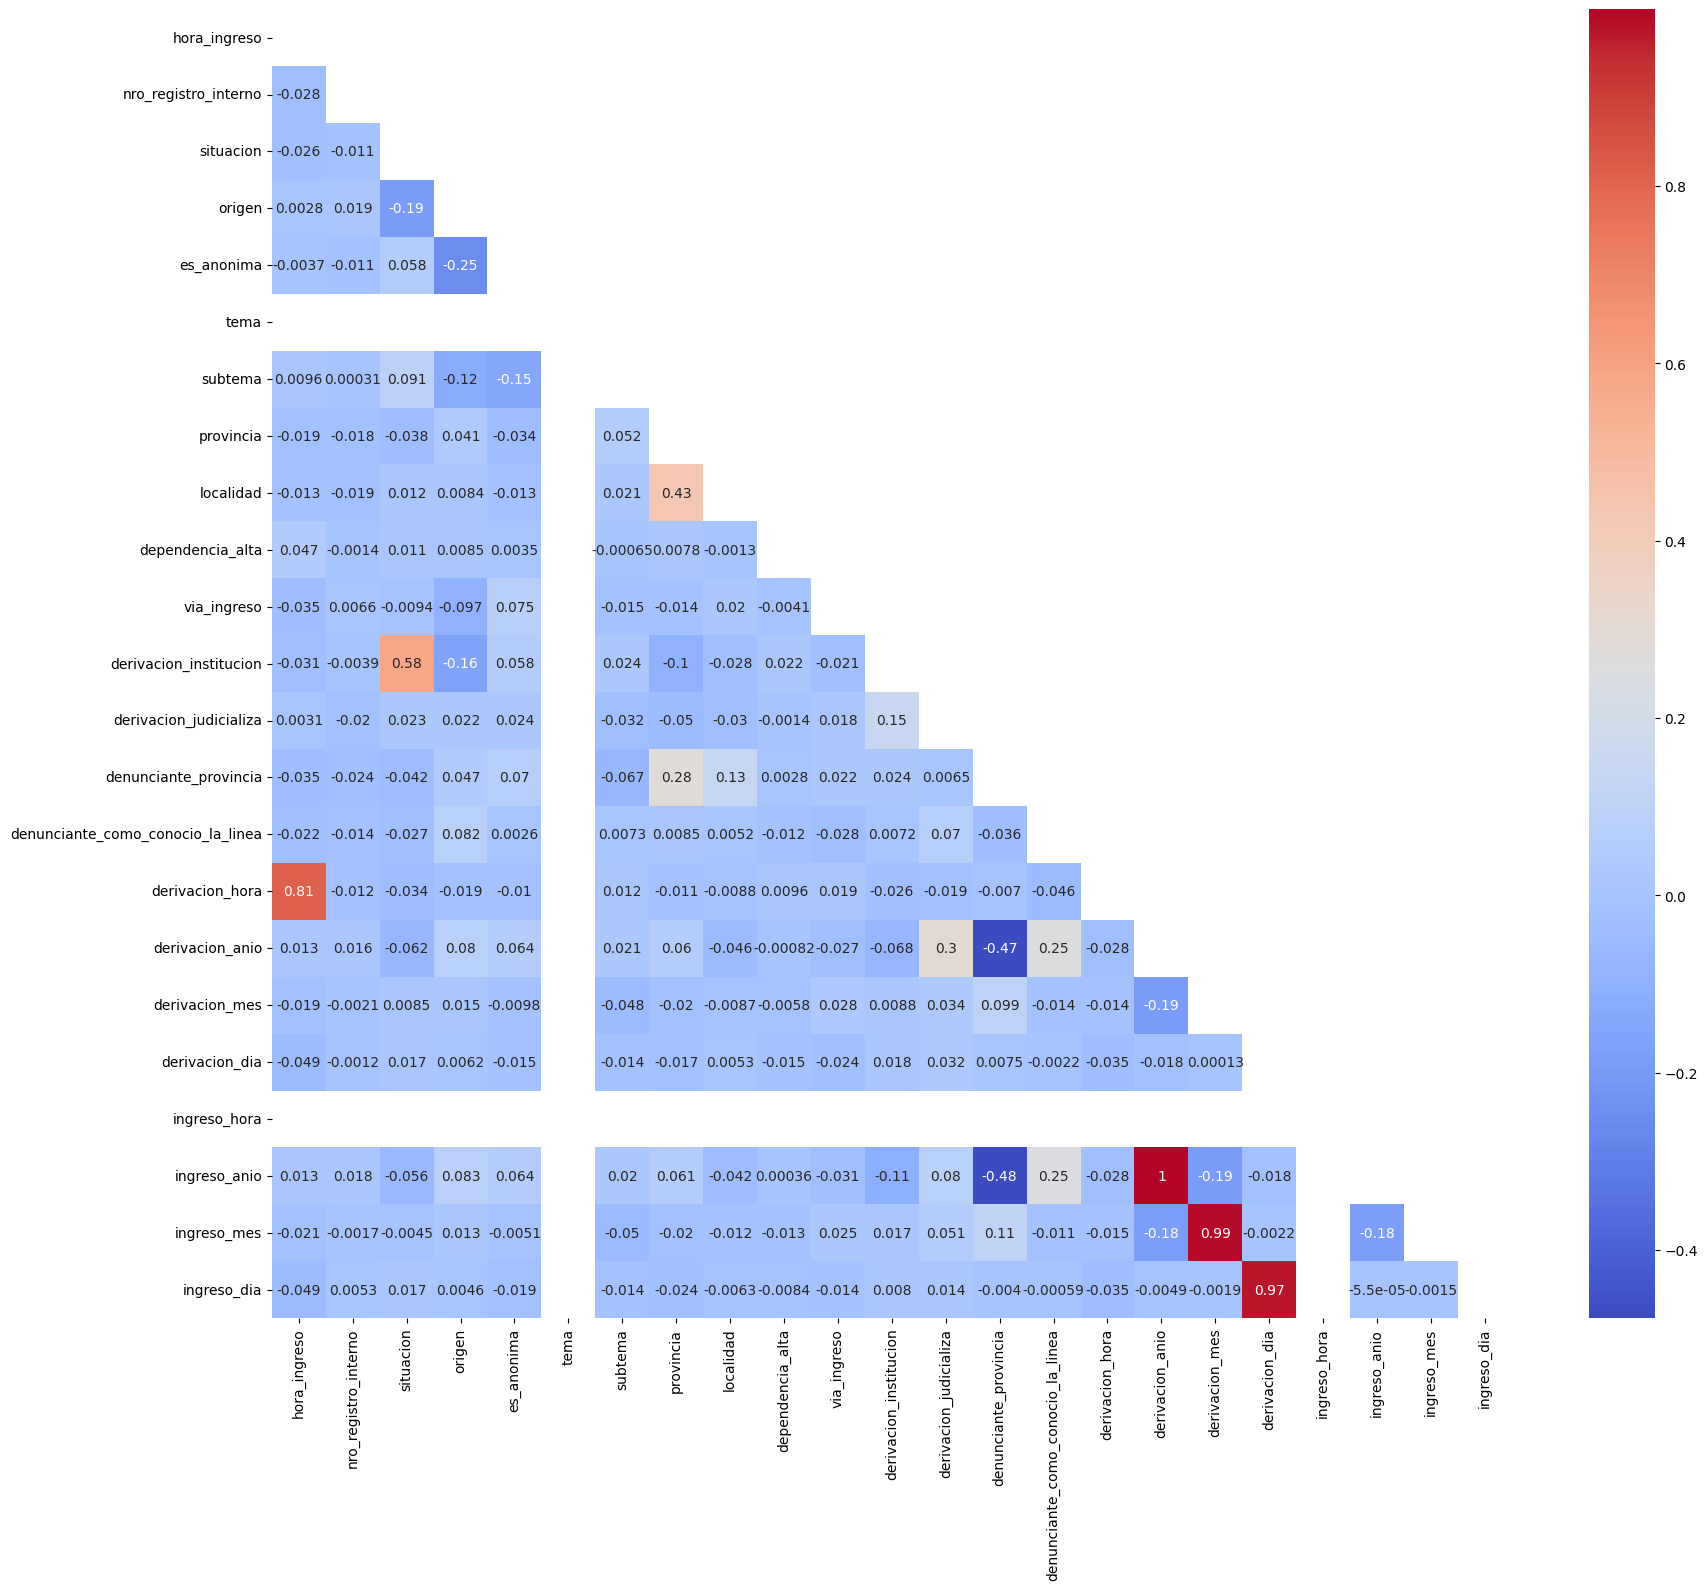

In [143]:
matriz_correlacion = df_denuncias_escalados.corr()
mascara_espejo = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
# Crear el mapa de calor con la mitad de la matriz
plt.figure(figsize=(20, 17))  # Ajusta los valores según tus necesidades
sns.heatmap(matriz_correlacion, mask=mascara_espejo, annot=True, cmap='coolwarm')
plt.show()

### 2.4.0 - ALMACENAMIENTO CSV

In [144]:
df_denuncias_codificados.to_csv('../datos/csv procesados/denuncias_codificados.csv', index=False)
df_denuncias_escalados.to_csv('../datos/csv procesados/denuncias_escalados.csv', index=False)
df_denuncias.to_csv('../datos/csv procesados/denuncias.csv', index=False)

# 2.O - CSV ORIENTACIONES


### 2.1 - IMPORTACION DE CSV

In [145]:
path_orientaciones = ('../datos/csv procesados/limpios_orientaciones.csv')
df_orientaciones = pd.read_csv(path_orientaciones)

In [146]:
df_orientaciones.sample(3, random_state=4)

,fecha_ingreso,hora_ingreso,nro_registro_interno,situacion,origen,es_anonima,tema,subtema,provincia,localidad,via_ingreso,consultante_provincia,consultante_como_conocio_la_linea,consultante_edad_aparente
3080,2022-01-30,19:38,2594759425,Urgencia,Ciudadano,Sí,Covid,Covid,Ciudad Autónoma de Buenos Aires,Buenos Aires,Línea 145,Buenos Aires,NaN,50.0
2539,2021-11-16,NaN,3545657515,Urgencia,Ciudadano,No,Salud,Salud mental,NaN,NaN,Línea 145,NaN,NaN,0.0
4073,2022-11-02,15:05,505456525,Urgencia,Ciudadano,Sí,Violencia de género,Psicológica,Jujuy,Ciudad Perico,Línea 145,Jujuy,NaN,50.0


### 2.2 - COLUMNAS

#### 2.2.1 - TIPOS DE DATOS

In [150]:
df_orientaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   hora_ingreso                       2358 non-null   float64
 1   nro_registro_interno               5278 non-null   int64  
 2   situacion                          5268 non-null   object 
 3   origen                             5278 non-null   object 
 4   es_anonima                         5278 non-null   object 
 5   tema                               5273 non-null   object 
 6   subtema                            5273 non-null   object 
 7   provincia                          3350 non-null   object 
 8   localidad                          3102 non-null   object 
 9   via_ingreso                        4639 non-null   object 
 10  consultante_provincia              2198 non-null   object 
 11  consultante_como_conocio_la_linea  829 non-null    objec

In [149]:
# Convertir derivacion_fecha_hora a hora del día
df_orientaciones['fecha_ingreso'] = pd.to_datetime(df_orientaciones['fecha_ingreso'])

# Obtener año, mes y día de derivacion_fecha en una sola línea
df_orientaciones['ingreso_anio'] = df_orientaciones['fecha_ingreso'].dt.year
df_orientaciones['ingreso_mes'] = df_orientaciones['fecha_ingreso'].dt.month
df_orientaciones['ingreso_dia'] = df_orientaciones['fecha_ingreso'].dt.day

df_orientaciones['hora_ingreso'] = pd.to_datetime(df_orientaciones['hora_ingreso']).dt.hour

df_orientaciones  = df_orientaciones.drop('fecha_ingreso', axis=1)

In [ ]:
categorias_cols = df_orientaciones.
df_orientaciones[categorias_cols] = df_orientaciones[categorias_cols].astype('category')

#### 2.2.2 - VALORES

In [ ]:
# Sin simbolos extranios a remplazar o extraer

#### 2.2.3 - CODIFICACION

In [152]:
columnas_categoricas.sample(3, random_state= 3)

,situacion,origen,es_anonima,tema,subtema,provincia,localidad,via_ingreso,consultante_provincia,consultante_como_conocio_la_linea
4372,Urgencia,Ciudadano,Sí,Violencias,Familiar > asesoramiento para realizar denuncia,Corrientes,Santo Tome,Línea 145,Corrientes,NaN
93,Urgencia,Ciudadano,Si,Trata,"Pornografía infantil, perverso",Córdoba,Córdoba,Línea 145,Córdoba,NaN
3129,Urgencia,Ciudadano,No,Trata,Salud mental,Ciudad Autónoma de Buenos Aires,Buenos Aires,Línea 145,Ciudad Autónoma de Buenos Aires,NaN


##### 2.2.3.0 - CATEGORICOS NOMINALES

In [151]:
columnas_categoricas = df_orientaciones.select_dtypes(include=['category', 'object'])
columnas_categoricas_nombres =  columnas_categoricas.columns

In [153]:
# Columnas categoricas nominales
df_orientaciones_codificados = df_orientaciones
for column in columnas_categoricas_nombres:
    encoder = LabelEncoder()
    df_orientaciones_codificados[column] = encoder.fit_transform(df_orientaciones_codificados[column].astype(str))

##### 2.2.3.1 - CATEGORICOS ORDINALES

In [ ]:
#Columnas categoricas ordinales
# No hay

#### 2.2.4 - ESCALAMIENTO

In [156]:
scaler = MinMaxScaler()
df_orientaciones_escalados = scaler.fit_transform(df_orientaciones_codificados.copy())
df_orientaciones_escalados = pd.DataFrame(df_orientaciones_escalados, columns = df_orientaciones.columns)

#### 2.2.5 - PORCENTAJE DE VALORES

In [157]:
df_orientaciones_escalados.isnull().sum()

hora_ingreso                         2920
nro_registro_interno                    0
situacion                               0
origen                                  0
es_anonima                              0
tema                                    0
subtema                                 0
provincia                               0
localidad                               0
via_ingreso                             0
consultante_provincia                   0
consultante_como_conocio_la_linea       0
consultante_edad_aparente            1306
ingreso_anio                            0
ingreso_mes                             0
ingreso_dia                             0
dtype: int64

#### 2.2.6 - MEDIDAS DE TENDENCIA CENTRAL

In [158]:
df_orientaciones.describe(include='all')

,hora_ingreso,nro_registro_interno,situacion,origen,es_anonima,tema,subtema,provincia,localidad,via_ingreso,consultante_provincia,consultante_como_conocio_la_linea,consultante_edad_aparente,ingreso_anio,ingreso_mes,ingreso_dia
count,2358.0,5.278000e+03,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,3972.000000,5278.000000,5278.000000,5278.000000
mean,0.0,5.052416e+09,0.993748,5.807313,0.705570,31.833839,396.057598,13.118606,344.686434,12.730390,16.844070,34.355438,28.099698,2021.370216,5.943729,15.751989
std,0.0,2.841749e+09,0.100022,29.554570,0.835817,5.864739,177.407365,10.198148,193.856540,5.127914,9.784088,8.918017,24.163614,1.068667,3.389398,8.849941
min,0.0,5.050505e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020.000000,1.000000,1.000000
25%,0.0,2.555659e+09,1.000000,0.000000,0.000000,30.000000,290.000000,3.000000,124.000000,11.000000,6.000000,38.000000,0.000000,2020.000000,3.000000,8.000000
50%,0.0,5.505156e+09,1.000000,0.000000,0.000000,34.000000,419.000000,14.000000,405.000000,11.000000,24.000000,38.000000,30.000000,2021.000000,6.000000,16.000000
75%,0.0,7.555158e+09,1.000000,0.000000,1.000000,34.000000,564.000000,24.000000,529.000000,11.000000,24.000000,38.000000,47.000000,2022.000000,9.000000,23.000000
max,0.0,9.494949e+09,2.000000,229.000000,2.000000,41.000000,745.000000,25.000000,540.000000,29.000000,24.000000,44.000000,94.000000,2023.000000,12.000000,31.000000


### 2.3.0 - CORRELACION

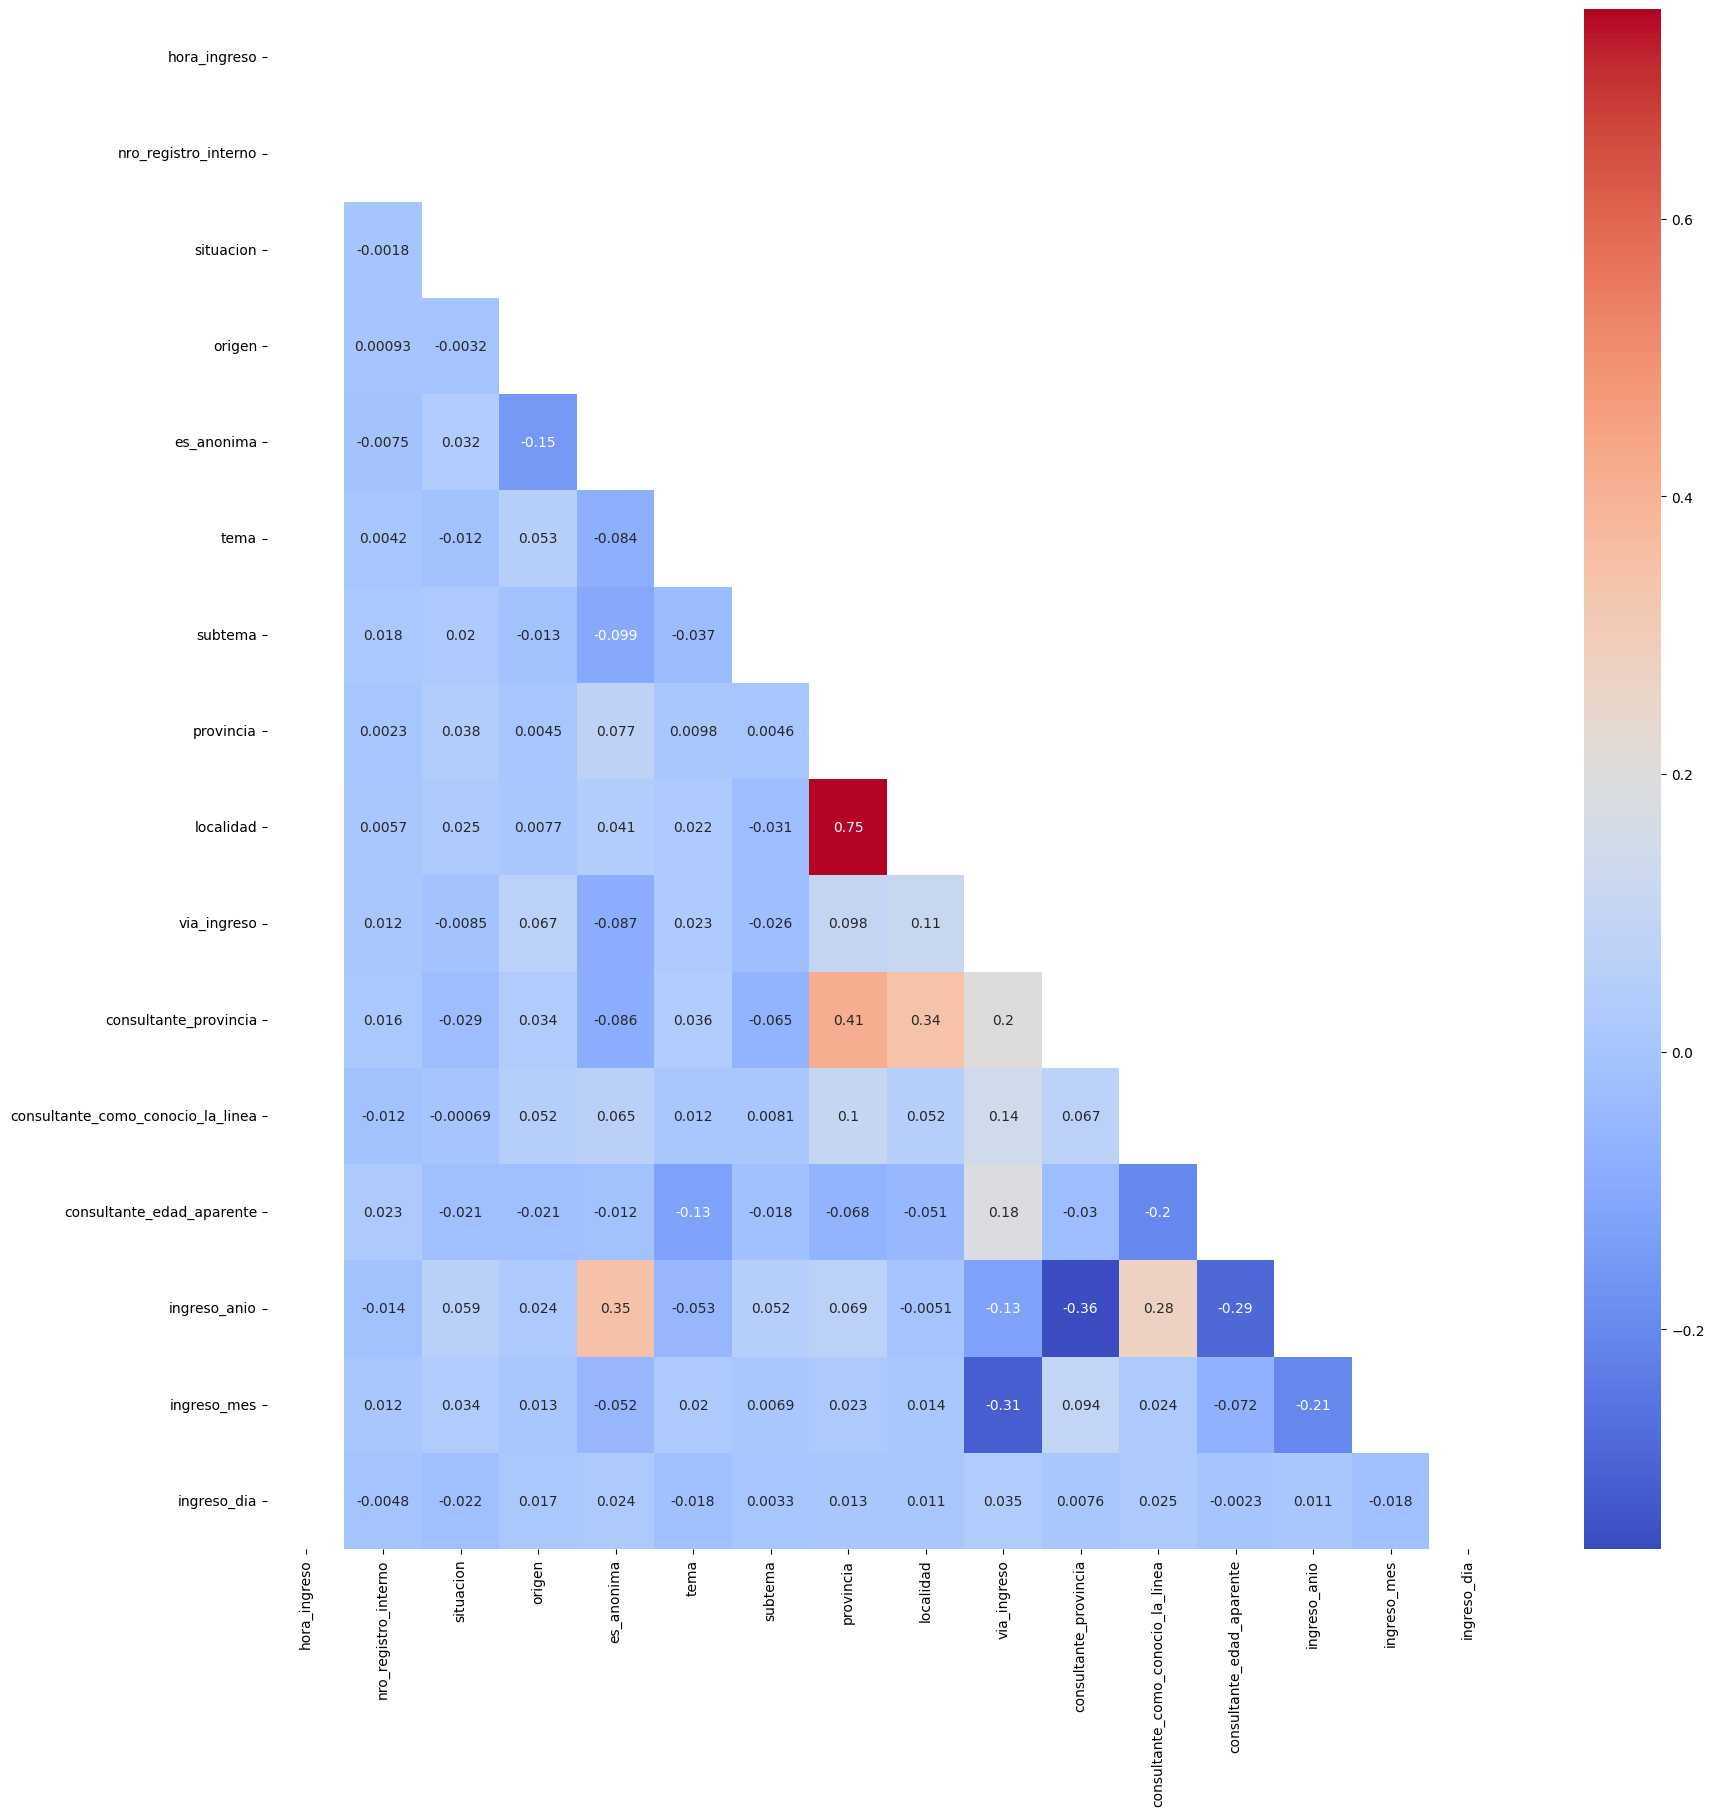

In [165]:
matriz_correlacion = df_orientaciones_escalados.corr()
mascara_espejo = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(matriz_correlacion, mask = mascara_espejo, annot=True, cmap = 'coolwarm')
plt.show()

### 2.4.0 - ALMACENAMIENTO CSV

In [167]:
df_orientaciones_codificados.to_csv('../datos/csv procesados/orientacion_codificados.csv', index=False)
df_orientaciones_escalados.to_csv('../datos/csv procesados/orientacion_escalados.csv', index=False)
df_orientaciones.to_csv('../datos/csv procesados/orientacion.csv', index=False)